In [1]:
import numpy as np
import pandas as pd
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import sys
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

In [57]:
bounds = {'pi': {'max': 0, 'min':-16, 'dim':17}, 'phi': {'max': -.25, 'min':-.4, 'dim':5}, 
          'theta': {'max':10, 'min': 0, 'dim':17}}
innov_dim = 1000

In [58]:
np.linspace(-.25, -.4, 5)

array([-0.25 , -0.287, -0.325, -0.363, -0.4  ])

In [55]:
accepted_vals.max()

phi     -0.266667
pi       0.000000
theta    6.000000
dtype: float64

In [54]:
accepted_vals.min()

phi      -0.366667
pi      -10.000000
theta     0.000000
dtype: float64

In [5]:
vl.__version__

'0.0.24-py37_0'

## Load the data

In [6]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 25.2 
    vol = store['discrete_vol_est'] * 25.2**2
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol'] 

In [7]:
data.head()

,rtn,vol
2003-01-02,0.641961,0.087998
2003-01-03,0.053996,0.077860
2003-01-06,0.515051,0.045863
2003-01-07,-0.089675,0.082945
2003-01-08,-0.274812,0.064468


In [8]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,rtn,vol
rtn,0.055233,-0.002298
vol,-0.002298,0.018866


In [9]:
data.corr()

,rtn,vol
rtn,1.000000,-0.024379
vol,-0.024379,1.000000


In [10]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.002342,0.056213
std,0.235017,0.144584
min,-2.078183,0.001233
25%,-0.095404,0.013806
50%,0.012830,0.024160
75%,0.109952,0.050309
max,1.803101,4.218808


In [11]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.002342,0.056213
std,0.235017,0.144584
min,-2.078183,0.001233
25%,-0.095404,0.013806
50%,0.012830,0.024160
75%,0.109952,0.050309
max,1.803101,4.218808


In [12]:
data_for_plot = data.copy()
data_for_plot.vol *= 100
data_for_plot.rtn *= 10

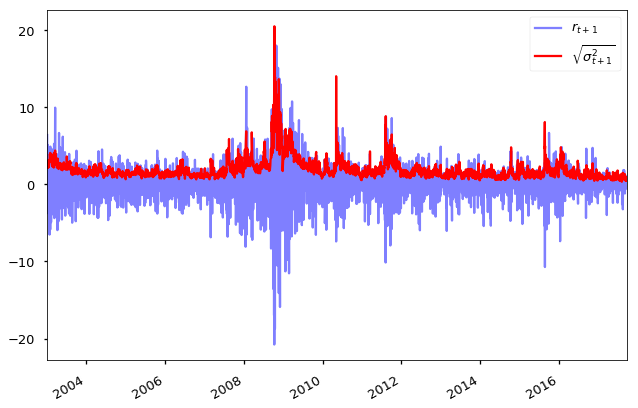

In [13]:
fig1, ax1 = mpl.pyplot.subplots()
data_for_plot['rtn'].plot(ax=ax1, color='blue', alpha=.5, label="$r_{t+1}$")
data_for_plot['vol'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{\sigma^2_{t+1}}$', color='red')
ax1.legend()
fig1.savefig('../doc/figures/time_series.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

(None,)

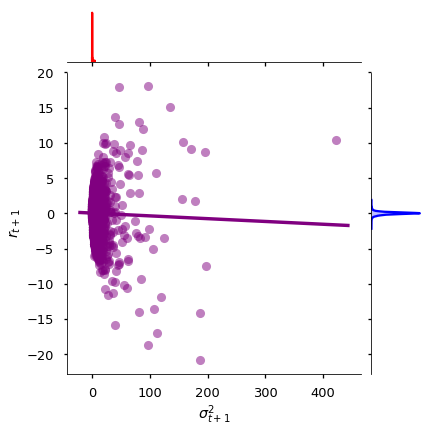

In [14]:
joint_grid = sns.JointGrid(x='vol', y='rtn', data=data_for_plot) #, xlim=[-.1, 3], ylim=[-2, 2])
joint_grid.plot_joint(sns.regplot, ci=None, color='purple', scatter_kws={"alpha":.5})
sns.kdeplot(data['vol'], ax=joint_grid.ax_marg_x, legend=None, shade=True, color='red')
sns.kdeplot(data['rtn'], ax=joint_grid.ax_marg_y, legend=None, shade=True, color='blue', vertical=True)
joint_grid.set_axis_labels("$\sigma^2_{t+1}$","$r_{t+1}$")
joint_grid.savefig('../doc/figures/joint_dist.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True),

In [15]:
data_for_plot.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.023421,5.621287
std,2.350165,14.458447
min,-20.781833,0.123335
25%,-0.954041,1.380618
50%,0.128299,2.416002
75%,1.099523,5.030940
max,18.031014,421.880784


In [16]:
stats.kurtosis(data_for_plot, fisher=False)

array([ 13.066, 243.401])

In [17]:
stats.skew(data_for_plot)

array([-0.312, 12.209])

In [18]:
data_for_plot.corr()

,rtn,vol
rtn,1.000000,-0.024379
vol,-0.024379,1.000000


## We now estimate the volatility paramters.

In [19]:
omega, omega_cov = vl.estimate_params_strong_id(data)

In [20]:
estimates, covariance = vl.estimate_params(data, *vl.compute_vol_gmm(data.vol))

In [21]:
estimates

{'gamma': 0.025965685942692985,
 'beta': 1.1135527707674162,
 'psi': -1.5373902507632218,
 'zeta': 0.9086856628806315,
 'log_both': -4.452604967194425,
 'log_scale': -3.4845225333344656,
 'logit_rho': 1.2143834912110452}

## I compute the point estimates and confidence intervals for the volatility parameters.

### c

In [22]:
(100 * np.exp(estimates['log_scale']),
100 * np.exp(estimates['log_scale'] - 1.96 * covariance.loc['log_scale', 'log_scale']**.5),
 100 * np.exp(estimates['log_scale'] + 1.96 * covariance.loc['log_scale', 'log_scale']**.5))


(3.066839807172146, 1.3842424643468563, 6.79469575967213)

### delta

In [23]:
log_mean = estimates['log_both'] - estimates['log_scale']
log_var = (covariance.loc['log_scale', 'log_scale'] + covariance.loc['log_both', 'log_both'] 
           - 2 * covariance.loc['log_scale', 'log_both'])
(100 * np.exp(log_mean),
 100 * np.exp(log_mean - 1.96 * log_var**.5),
 100 * np.exp(log_mean + 1.96 * log_var**.5)
)

(37.98106523027487, 17.652851338176877, 81.71831781683024)

### rho

In [24]:
mean = estimates['logit_rho']
std = covariance.loc['logit_rho', 'logit_rho']**.5
(special.expit(mean), special.expit(mean - 1.96 * std), special.expit(mean + 1.96*std))

(0.7710736381771802, 0.6747180737957077, 0.845425558628928)

In [25]:
covariance

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.009748,-0.000035,0.000000,0.000000,0.000000,-0.009132,0.000000
gamma,-0.000035,0.000006,0.000000,0.000000,0.000000,-0.000080,0.000000
log_both,0.000000,0.000000,0.020524,0.016218,-0.031927,0.000000,0.000000
log_scale,0.000000,0.000000,0.016218,0.164726,0.005153,0.000000,0.000000
logit_rho,0.000000,0.000000,-0.031927,0.005153,0.061176,0.000000,0.000000
psi,-0.009132,-0.000080,0.000000,0.000000,0.000000,0.014926,0.000000
zeta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000431


In [26]:
data.vol.sort_values(ascending=True).head()

2017-08-07    0.001233
2017-09-14    0.002147
2017-09-22    0.002169
2016-11-25    0.002262
2017-07-24    0.002427
Name: vol, dtype: float64

In [27]:
omega2, omega_cov2 = vl.estimate_params(data)

In [28]:
qlr_stats = vl.compute_qlr_stats(omega=omega2, omega_cov=omega_cov2, theta_dim=bounds['theta']['dim'],
                               pi_dim=bounds['pi']['dim'], phi_dim=bounds['phi']['dim'],
                               pi_min=bounds['pi']['min'], pi_max=bounds['pi']['max'], 
                               phi_min=bounds['phi']['min'], phi_max=bounds['phi']['max'],
                               theta_min=bounds['theta']['min'], theta_max=bounds['theta']['max'],
                                 use_tqdm=True)

In [29]:
qlr_draws = vl.compute_qlr_sim(omega=omega2, omega_cov=omega_cov2, theta_dim=bounds['theta']['dim'],
                               pi_dim=bounds['pi']['dim'], phi_dim=bounds['phi']['dim'],
                               pi_min=bounds['pi']['min'], pi_max=bounds['pi']['max'], 
                               phi_min=bounds['phi']['min'], phi_max=bounds['phi']['max'],
                               theta_min=bounds['theta']['min'], theta_max=bounds['theta']['max'],
                               use_tqdm=True, alpha=0.05, innov_dim=innov_dim)

In [30]:
qlr_draws.head()

,phi,pi,theta,qlr
0,-0.4,-10.0,0.000,4.023851
3,-0.4,-10.0,0.375,6.608068
2,-0.4,-10.0,0.750,6.570343
1,-0.4,-10.0,1.125,7.233681
4,-0.4,-10.0,1.500,7.546361


In [31]:
qlr_draws.head()

,phi,pi,theta,qlr
0,-0.4,-10.0,0.000,4.023851
3,-0.4,-10.0,0.375,6.608068
2,-0.4,-10.0,0.750,6.570343
1,-0.4,-10.0,1.125,7.233681
4,-0.4,-10.0,1.500,7.546361


In [32]:
qlr_stats.count()

phi      2023
pi       2023
theta    2023
qlr      2023
dtype: int64

In [33]:
# merged_values = qlr_stats.merge(qlr_draws, how='outer', on=['phi', 'pi', 'theta'], suffixes=['_stats', '_draws']).dropna()

In [34]:
merged_values = vl.merge_draws_and_sims(qlr_stats, qlr_draws)

In [35]:
merged_values

,phi,pi,theta,qlr_draws,qlr_stats
0,-0.4,-10.000,0.000,103.483797,4.023851
1,-0.4,-10.000,3.000,68.724083,6.935534
2,-0.4,-10.000,1.125,25.779771,7.233681
3,-0.4,-10.000,0.375,8.008727,6.608068
4,-0.4,-10.000,1.500,26.311319,7.546361
5,-0.4,-10.000,0.750,87.950274,6.570343
6,-0.4,-10.000,6.000,206.044186,0.000000
7,-0.4,-10.000,3.750,386.222745,6.751201
8,-0.4,-10.000,2.625,632.587092,6.638608
9,-0.4,-10.000,2.250,946.724714,6.748911


In [36]:
accepted_vals = merged_values.query('qlr_stats > qlr_draws').drop(['qlr_draws', 'qlr_stats'], axis='columns')

In [37]:
qlr_draws.to_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region_flattened.tmp.json')

In [38]:
qlr_draws = pd.read_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region_flattened.tmp.json')

In [39]:
qlr_draws.head()

,phi,pi,theta,qlr
0,-0.4,-10.00,0.000,4.023851
1,-0.4,-10.00,1.125,7.233681
10,-0.4,-10.00,4.875,6.059196
100,-0.4,-6.25,0.000,6.469519
1000,-0.3,-5.00,0.000,6.785905


In [40]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

In [41]:
omega

{'gamma': 0.025965685942692985,
 'beta': 1.1135527707674162,
 'psi': -1.5373902507632218,
 'zeta': 0.9086856628806315,
 'log_both': -4.452604967194425,
 'log_scale': -3.4845225333344656,
 'logit_rho': 1.2143834912110452,
 'phi': -0.3102337755314673,
 'pi': -20.0,
 'theta': 0.28664215551939315}

In [42]:
accepted_vals.head()

,phi,pi,theta
291,-0.366667,-10.000,0.000
308,-0.366667,-10.000,5.250
343,-0.366667,-8.125,2.625
360,-0.366667,-7.500,2.625
377,-0.366667,-6.875,0.000


In [43]:
accepted_vals.min()

phi      -0.366667
pi      -10.000000
theta     0.000000
dtype: float64

In [51]:
bounds

{'pi': {'max': 0, 'min': -10, 'dim': 17},
 'phi': {'max': -0.2, 'min': -0.4, 'dim': 7},
 'theta': {'max': 6, 'min': 0, 'dim': 17}}

In [44]:
accepted_vals.max()

phi     -0.266667
pi       0.000000
theta    6.000000
dtype: float64

In [70]:
bounds

{'pi': {'max': 0, 'min': -10, 'dim': 17},
 'phi': {'max': -0.25, 'min': -0.4, 'dim': 5},
 'theta': {'max': 6, 'min': 0, 'dim': 17}}

In [73]:
pi_patch_height

0.5882352941176471

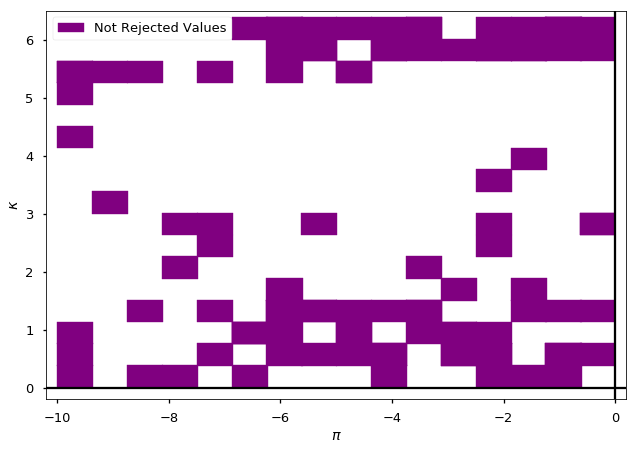

In [88]:
fig3, ax3 = mpl.pyplot.subplots()
pi_patch_width = 1.1 * (bounds['pi']['max'] - bounds['pi']['min']) / bounds['pi']['dim']
theta_patch_height = 1.1 * (bounds['theta']['max'] - bounds['theta']['min']) / bounds['theta']['dim']
for row in accepted_vals.itertuples(index=False):
#     print(row)
    patch = mpl.patches.Rectangle((row.pi, row.theta), width=pi_patch_width, height=theta_patch_height,
                                  fill=True, color='purple')
    ax3.add_patch(patch)
# ax3.scatter(y=accepted_vals.theta, x=accepted_vals.pi, marker='s', s=650, label='Not Rejected Values',
#            color='purple')

max_y = bounds['theta']['max']
min_x = bounds['pi']['min']

yvals = np.linspace(0,max_y+1,100)
xvals = [constraint(np.exp(omega['log_scale']), omega['psi'], omega['zeta'], x) for x in yvals]
ax3.plot(xvals, yvals, color='black', label='Constraint')
ax3.axvline(0,  ymin=0, ymax=1, color='black')
ax3.axhline(0,  xmin=1, xmax=0, color='black')

white_rect1 = mpl.patches.Rectangle((0,-1), 2, max_y + 2, angle=0.0, color='white', fill=True)
white_rect2 = mpl.patches.Rectangle((min_x-1,-1), abs(min_x) + 2, 1, angle=0.0, color='white', fill=True)
ax3.add_patch(white_rect1)
ax3.add_patch(white_rect2)
ax3.set_ylim([-.2, max_y+.5])
ax3.set_xlim([min_x - .2, .2])
ax3.set_ylabel(r'$\kappa$')
ax3.set_xlabel(r'$\pi$')
ax3.legend(handles=[patch], labels=['Not Rejected Values'], loc='upper left')

fig3.savefig(f'../doc/figures/confidence_region_{innov_dim}.tmp.pdf', frameon=False, pad_inches=0, 
             bbox_inches='tight', transparent=True)

In [46]:
qlr_draws_pivoted = qlr_draws[np.isclose(qlr_draws.phi, accepted_vals.phi.value_counts().argmax())].drop(columns=['phi']).pivot(
    columns='pi',index='theta', values='qlr').sort_index(by='theta', ascending=False)

In [47]:
stats.chi2.ppf(.95, df=4)

9.487729036781154

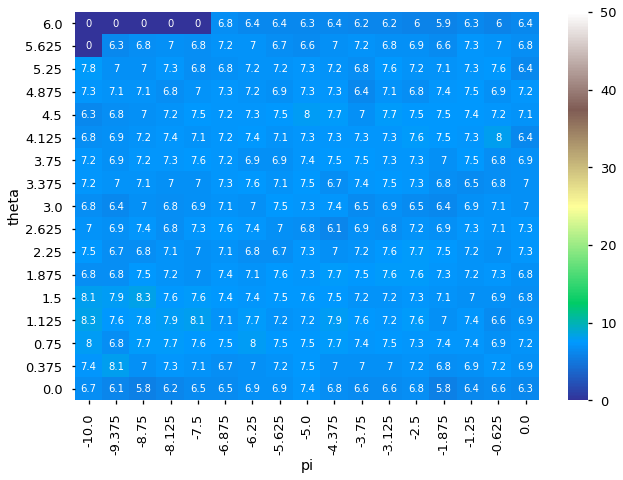

In [48]:
sns.heatmap(qlr_draws_pivoted, annot=True,  cmap=mpl.cm.get_cmap('terrain'), vmin=0, vmax=50)

In [60]:
qlr_stats_pivoted = qlr_stats[np.isclose(qlr_stats.phi, accepted_vals.phi.value_counts().argmax())].drop(columns=['phi']).pivot(
    columns='pi',index='theta', values='qlr').sort_index(axis='index').sort_index(by='theta', ascending=False)

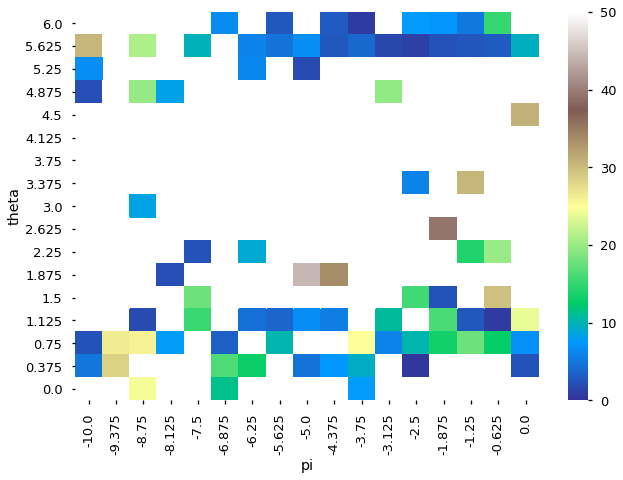

In [62]:
sns.heatmap(qlr_stats_pivoted, annot=False, cmap=mpl.cm.get_cmap('terrain'), vmin=0, vmax=50)